1. Differentiate between random and stratified sampling?
2. Generate a random dataset and perform training and testing split using stratified
sampling?
3. Take a dataset and create a transformer pipeline to select the most important
parameters.
4. With respect to the above dataset create a single pipeline for data preparation and
final prediction.
5. Try to perform hyperparameter tuning using Evolutionary algorithms by taking a
suitable dataset.

### Answer1

Simple random samples and stratified random samples are both statistical measurement tools. A simple random sample is used to represent the entire data population. A stratified random sample divides the population into smaller groups, or strata, based on shared characteristics.

In short, it ensures each subgroup within the population receives proper representation within the sample. As a result, stratified random sampling provides better coverage of the population since the researchers have control over the subgroups to ensure all of them are represented in the sampling.

### Answer2

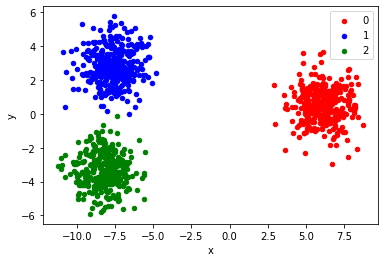

In [36]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
import pandas as pd
import numpy as np


# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2,random_state=999)
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


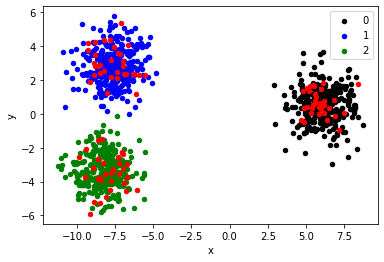

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

df = pd.DataFrame(dict(x=X_train[:,0], y=X_train[:,1], label=y_train))
colors = {0:'black', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
#pyplot.show()

df = pd.DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_test))
#colors = {0:'red', 1:'blue', 2:'green'}
#fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
pyplot.show()

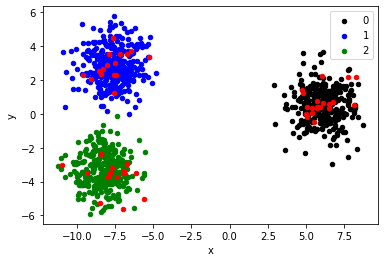

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=None, 
                                                    test_size=0.05)

df = pd.DataFrame(dict(x=X_train[:,0], y=X_train[:,1], label=y_train))
colors = {0:'black', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
#pyplot.show()

df = pd.DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_test))
#colors = {0:'red', 1:'blue', 2:'green'}
#fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
pyplot.show()

In stratify it takes equal number of samples for each class where in randomsample it may differ

### Answer3

In [80]:
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.svm import SVC

model = Pipeline([
   ('feature_selector', GenericUnivariateSelect(
      mode='percentile',
      param=0.20,          # hyper-tunable parameter
   )),
   ('model', LinearRegression())
])

model.fit(X, y)

# Predict training data
y_train_pred = model.predict(X[0].reshape(1, -1))
print(f"Predictions on training data: {y_train_pred}")
print(f"Actual value on training data: {y[0]}")


Predictions on training data: [1.60097627]
Actual value on training data: 2


### Answer4

In [55]:
from seaborn import load_dataset
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression

# Set seed for reproducibility
seed = 123

# Load dataset
df = load_dataset('tips').drop(columns=['tip', 'sex']).sample(n=5, random_state=seed)

# Add missing values
df.iloc[[1, 2, 4], [2, 4]] = np.nan
df

,total_bill,smoker,day,time,size
112,38.07,No,Sun,Dinner,3.0
19,20.65,No,NaN,Dinner,NaN
187,30.46,Yes,NaN,Dinner,NaN
169,10.63,Yes,Sat,Dinner,2.0
31,18.35,No,NaN,Dinner,NaN


In [64]:

# Partition data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['total_bill', 'size']), 
                                                    df['total_bill'], 
                                                    test_size=.2, 
                                                    random_state=seed)

In [77]:
# Fit pipeline to training data
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)), 
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")


Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


In [78]:
print(y_train)
print(y_test)

169    10.63
31     18.35
112    38.07
187    30.46
Name: total_bill, dtype: float64
19    20.65
Name: total_bill, dtype: float64


### Answer5

In [83]:
!pip install sklearn-genetic-opt

In [85]:
from sklearn_genetic import GASearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30), 
              'max_leaf_nodes': Integer(2, 35), 
              'n_estimators': Integer(100, 300)}

cv = StratifiedKFold(n_splits=3, shuffle=True)

clf = RandomForestClassifier()

evolved_estimator = GASearchCV(estimator=clf,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [88]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

data = load_digits() 

n_samples = len(data.images)
X = data.images.reshape((n_samples, -1))
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

In [89]:
evolved_estimator.fit(X_train,y_train)
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.852895	0.0665949  	0.91466    	0.680933   
1  	18    	0.892756	0.02523    	0.920277   	0.829392   
2  	20    	0.894809	0.0297357  	0.924002   	0.820112   
3  	19    	0.90928 	0.0110357  	0.922077   	0.892344   
4  	19    	0.915958	0.00995869 	0.931357   	0.894269   
5  	17    	0.922262	0.00515412 	0.931357   	0.914577   
6  	18    	0.925795	0.00476684 	0.931357   	0.918353   
7  	18    	0.927835	0.00418691 	0.931357   	0.920226   
8  	19    	0.927262	0.00369857 	0.931357   	0.920226   
9  	19    	0.927644	0.00511842 	0.935051   	0.920205   
10 	16    	0.929123	0.00509878 	0.935051   	0.920226   
11 	18    	0.932644	0.00370852 	0.935051   	0.92576    
12 	15    	0.932456	0.00363008 	0.935051   	0.92576    
13 	19    	0.929127	0.00536826 	0.935051   	0.920194   
14 	19    	0.929501	0.00445651 	0.935051   	0.922046   
15 	17    	0.93079 	0.00431033 	0.935051   	0.92574    
16 	19    	0.92839 	0.00550722 	0.935051   	0.91

0.93879173290938